In [335]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [336]:
def mn_to_j(m: int, n: int) -> int:
    """
    Translate m, n indexing scheme to j (OSA/ANSI) indexing scheme

    Parameters:
    -----------
    m : int
        zernike index m (Azimuthal degree)
    n : int
        zernike index n (Radial degree)

    Returns:
    --------
    int
        zernike index j (OSA indexing)
    """
    return int((n * (n + 2) + m) / 2)


def j_to_mn(j: int):
    """
    Translate single indexing scheme (OSA/ANSI) to m, n indexing

    Parameters:
    -----------
    j : int
        zernike index j (OSA indexing)

    Returns:
    --------
    Tuple[int, int]
        zernike index m (Azimuthal degree) , n (Radial degree)
    """
    n = int(np.sqrt(2*j+1) + 0.5 - 1)
    m = int(2*j - n*(n+2))
    return m, n

def radial_j(j: int):
    rho = sp.symbols('rho', real=True)
    m, n = j_to_mn(j)
    # print(f"n: {n} | m: {m}")
    z = 0
    m = abs(m)
    K = (n-m)//2
    # print(f"K: {K}")
    for k in range(K+1):
        upper =((-1)**k*np.math.factorial(n-k))*rho**(n - 2*k)
        lower = np.math.factorial(k)*np.math.factorial((n+m)//2-k)*np.math.factorial((n-m)//2 - k)
        f = upper / lower
        z += f
    return z

def triangular_j(j: int):
    theta = sp.symbols("theta", real=True)
    m, n = j_to_mn(j)
    return sp.cos(m*theta) if m >= 0 else sp.sin(abs(m)*theta)

def norm_j(j: int):
    m, n = j_to_mn(j)
    return sp.sqrt(n + 1) if m == 0 else sp.sqrt(2*(n+1))

def zernike_radial_j(j: int):
    return sp.simplify(norm(j)*radial_j(j)*triangular_j(j))

def generate_zernike_functions_radial(n_zernike: int):
    z = []
    rho, theta = sp.symbols("rho theta", real=True)
    z.append(lambda rho, theta: np.ones_like(rho))
    for i in range(1, n_zernike):
        z.append(sp.lambdify((rho, theta), zernike_radial_j(i)))
    return z

def generate_zernike_pyramid(n_zernike: int, file_path: str, show_formula: bool = False):
    z = generate_zernike_functions_radial(n_zernike)
    for i in range(0, n_zernike - 1):
        fig = plt.figure(1, figsize=(18, 20), dpi=100)
        fig.tight_layout()
        _, n_max = j_to_mn(n_zernike - 1)
        n_max = (n_max+1)*2
        m, n = j_to_mn(i)
        index_x = (n_max // 2) + m
        index_y = n
        index = (index_x) + (index_y*n_max)
        plt.subplot(n_max, n_max, index)
        x = np.linspace(-1, 1, 400)
        y = x
        xx, yy = np.meshgrid(x, y)
        rho = np.sqrt(xx**2 + yy**2)
        theta = np.arctan2(yy, xx)
        zernike = z[i](rho, theta)
        zernike[xx**2 + yy**2 > 1] = np.nan
        plt.imshow(zernike, cmap='Spectral')
        if show_formula:
            plt.title(f"${sp.latex(zernike_radial_j(i))}$")
        plt.axis('off')
    plt.savefig(file_path)

def zernike_carthesian_j(j: int):
    x, y = sp.symbols('x y', real=True)
    l, n = j_to_mn(j)
    m = (n - abs(l))//2
    q = 0
    p = 1 if l > 0 else 0
    if l % 2 == 0:
        q = abs(l)//2-1 if l > 0 else abs(l)//2
    else:
        q = (abs(l)-1)//2
    z = 0
    for i in range(q+1):
        for j in range(m+1):
            h = 0
            for k in range(m - j + 1):
                h += np.math.comb(abs(l), 2*i+p)*np.math.comb(m - j, k)\
                *(np.math.factorial(n-j)\
                /(np.math.factorial(j)\
                *np.math.factorial(m-j)\
                *np.math.factorial(n-m-j)))\
                *x**(n-2*(i+j+k)-p)\
                *y**(2*(i+k)+p)
            z += (-1)**(i+j)*h
    return sp.simplify(z)

def zernike_carthesian_dx_j(j: int):
    x, y = sp.symbols('x y', real=True)
    return sp.diff(zernike_carthesian_j(j), x)

def zernike_carthesian_dy_j(j: int):
    x, y = sp.symbols('x y', real=True)
    return sp.diff(zernike_carthesian_j(j), y)

def generate_zernike_functions_carthesian(n_zernikes: int):
    z = []
    x, y = sp.symbols("x y", real=True)
    z.append(lambda rho, theta: np.ones_like(rho))
    for i in range(1, n_zernike):
        z.append(sp.lambdify((x, y), zernike_carthesian_j(i)))
    return z

def generate_zernike_functions_carthesian_dx(n_zernikes: int):
    z = []
    z.append(lambda x, y: np.zeros_like(x))
    x, y = sp.symbols("x y", real=True)
    for i in range(1, n_zernike):
        z_dx = zernike_carthesian_dx_j(i)
        if z_dx.has(x) or z_dx.has(y):
            f = sp.lambdify([x, y], z_dx.expand(), 'numpy')
            z.append(f)
        else:
            const = float(z_dx)
            z.append(lambda x, y: const*np.ones_like(x))
    return z

def generate_zernike_functions_carthesian_dy(n_zernikes: int):
    z = []
    z.append(lambda x, y: np.zeros_like(y))
    for i in range(1, n_zernike):
        x, y = sp.symbols("x y", real=True)
        z_dy = zernike_carthesian_dy_j(i)
        if z_dy.has(x) or z_dy.has(y):
            f = sp.lambdify([x, y], z_dy.expand())
            z.append(f)
        else:
            const = float(z_dy)
            z.append(lambda x, y: const*np.ones_like(x))
    return z

def generate_zernike_pyramid_dx(n_zernike: int, file_path: str, show_formula: bool = False):
    z = generate_zernike_functions_carthesian_dx(n_zernike)
    for i in range(0, n_zernike - 1):
        fig = plt.figure(1, figsize=(18, 20), dpi=100)
        fig.tight_layout()
        _, n_max = j_to_mn(n_zernike - 1)
        n_max = (n_max+1)*2
        m, n = j_to_mn(i)
        index_x = (n_max // 2) + m
        index_y = n
        index = (index_x) + (index_y*n_max)
        plt.subplot(n_max, n_max, index)
        x = np.linspace(-1, 1, 400)
        y = x
        xx, yy = np.meshgrid(x, y)
        zernike = z[i](xx, yy)
        zernike[xx**2 + yy**2 > 1] = np.nan
        plt.imshow(zernike, cmap='Spectral')
        if show_formula:
            plt.title(f"${sp.latex(zernike_carthesian_dx_j(i))}$")
        plt.axis('off')
    plt.savefig(file_path)

def generate_zernike_pyramid_dy(n_zernike: int, file_path: str, show_formula: bool = False):
    z = generate_zernike_functions_carthesian_dy(n_zernike)
    for i in range(0, n_zernike - 1):
        fig = plt.figure(1, figsize=(18, 20), dpi=100)
        fig.tight_layout()
        _, n_max = j_to_mn(n_zernike - 1)
        n_max = (n_max+1)*2
        m, n = j_to_mn(i)
        index_x = (n_max // 2) + m
        index_y = n
        index = (index_x) + (index_y*n_max)
        plt.subplot(n_max, n_max, index)
        x = np.linspace(-1, 1, 400)
        y = x
        xx, yy = np.meshgrid(x, y)
        zernike = z[i](xx, yy)
        zernike[xx**2 + yy**2 > 1] = np.nan
        plt.imshow(zernike, cmap='Spectral')
        if show_formula:
            plt.title(f"${sp.latex(zernike_carthesian_dy_j(i))}$")
        plt.axis('off')
    plt.savefig(file_path)

/tmp/ipykernel_3476/1759219278.py:77: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.tight_layout()


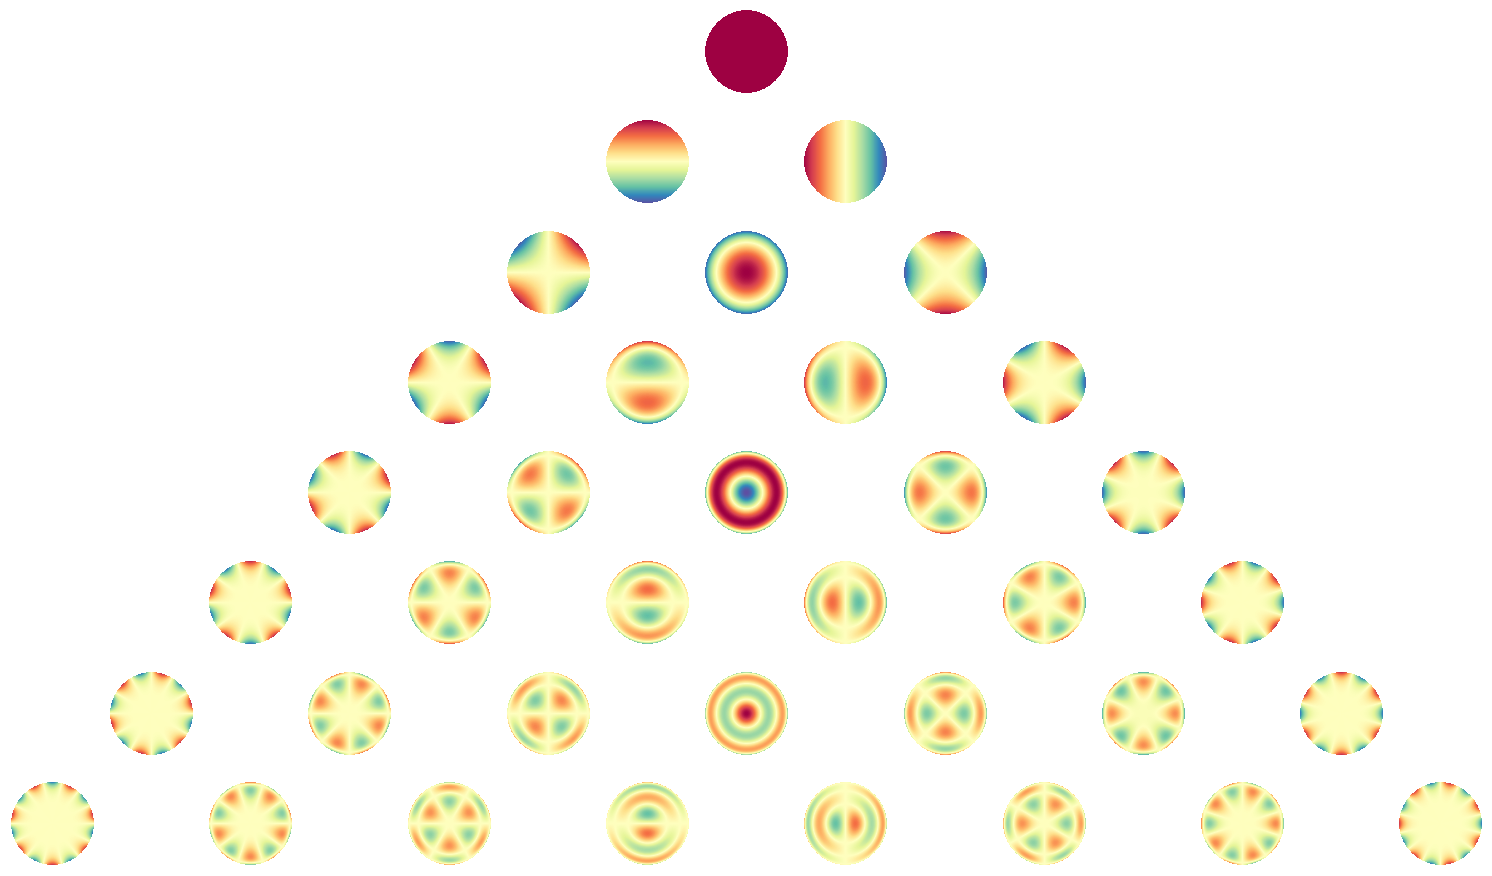

In [337]:
generate_zernike_pyramid_dx(16, "zernike_dx.png")
generate_zernike_pyramid_dy(16, "zernike_dy.png")
generate_zernike_pyramid(37, "zernike.png")